In [195]:
import argparse

from utils.logger import get_logger
from utils.arg_parser import Argments
from loader.data_loader import GeneralDataLoaderCls, NbsDataLoaderCls,\
                               GeneralDataLoaderSeg, NbsDataLoaderSeg,NbsDataLoaderRgs
from runners.cnn_runner import CnnRunner
from runners.nbs_runner import NbsRunner
from runners.mcd_runner import McdRunner
from models.regression import Reg_model
import torch
import numpy as np
from tqdm import tqdm
from runners.base_runner import gather_tensor

print(torch.cuda.is_available())

True


In [196]:
Reg_model

models.regression.Reg_model

In [197]:
from models.__init__ import _get_model

In [198]:
model = _get_model('Reg_model','nbs',1)

In [199]:
argparser = argparse.ArgumentParser()
# adding the values
argparser.add_argument("yaml")
argparser.add_argument("--phase", default="train", type=str) 
argparser.add_argument("--index", default=-1, type=int) 
argparser.add_argument("--gpus", default="0", type=str)
argparser.add_argument("--local_rank", default=-1, type=int) 
# save 
cmd_args = argparser.parse_args(["example"])

arg = Argments(f"scripts/{cmd_args.yaml}.yaml", cmd_args) # stll many funcs to read
setup = arg['setup']
model_path = arg['path/model_path']
logger = get_logger(f"{model_path}/log.txt")

if setup['rank'] == 0:
    logger.info(arg)

model_type = setup['model_type']
dataset = arg['path/dataset']
is_seg = False

if 'nbs' in model_type: # added in n_a (comparing the else loop)
        
    _data_loader = NbsDataLoaderRgs # n_a exists
    data_loader = _data_loader(dataset, setup['batch_size'],
                                setup['n_a'], setup['cpus'], setup['seed'])
    runner = NbsRunner(data_loader, **arg.module, num_epoch=setup['num_epoch'], # core part 
                        logger=logger, model_path=model_path, rank=setup['rank'],
                        epoch_th=setup['epoch_th'], num_mc=setup['num_mc'],
                        adv_training=setup['adv_training'])

setting the python env
cmd_args.local_rank:  -1
torch.Size([100000, 100])
torch.Size([100000, 1])
here1
here3
here4
here2


In [200]:
runner.load('best.pth')
loader = runner.loader.load('test')
if runner.rank == 0:
    t_iter = tqdm(loader, total=runner.loader.len)
else:
    t_iter = loader

outputs = []
labels = []
metrics = []
runner.model.eval()
for img, label in t_iter:
    _metric, output = runner._valid_a_batch(img, label, with_output=True)
    labels += label.cpu().squeeze().tolist()
    outputs += output.cpu().mean(0).squeeze().tolist() # gather_tensor(output).cpu().numpy()
    metrics += [_metric.cpu().item()] # gather_tensor(_metric).cpu().numpy()
# labels = np.concatenate(labels)
# outputs = np.concatenate(outputs, axis=1)
err = np.mean(metrics[:])
# nll, brier = calc_nll_brier_mc(outputs, labels)
# print("Becarful, the num_class set as 1")
print(f"[Test] loss: {err:.5f} ")
# log += f"NLL : {nll:.2f}, Brier : {brier:.2f}"


[Test] loss: 0.53616 


In [209]:
torch.tensor(labels).size()

torch.Size([2000])

In [201]:
print(len(labels))
print(len(outputs))

2000
2000


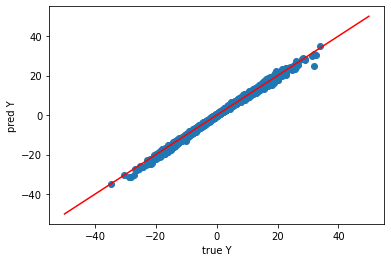

In [202]:
import matplotlib.pyplot as plt
plt.plot([-50,50],[-50,50],color="red")
plt.scatter(labels,outputs)
plt.xlabel("true Y")
plt.ylabel("pred Y")
plt.show()

In [203]:
import seaborn as sns

In [204]:
import pandas as pd
df = pd.DataFrame({"labels":labels,"outputs":outputs})
df

,labels,outputs
0,-6.685635,-7.422137
1,5.594200,5.654073
2,-13.835152,-13.313194
3,0.756599,1.139630
4,24.715645,22.967899
...,...,...
1995,3.251232,3.555114
1996,10.103464,9.967484
1997,1.942006,2.304214
1998,20.128458,17.987003


In [205]:
df.round()

,labels,outputs
0,-7.0,-7.0
1,6.0,6.0
2,-14.0,-13.0
3,1.0,1.0
4,25.0,23.0
...,...,...
1995,3.0,4.0
1996,10.0,10.0
1997,2.0,2.0
1998,20.0,18.0


In [206]:
ndf = df.copy()
ndf.outputs = ndf.outputs.round()
ndf.labels = ndf.labels.round()

In [207]:
df.outputs.ytpe

AttributeError: 'Series' object has no attribute 'ytpe'

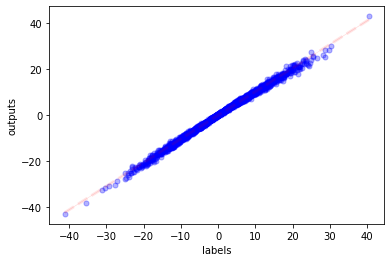

In [ ]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"labels":labels,"outputs":outputs})
sns.regplot(x="labels",y="outputs",data=df,color="r",x_ci="ci",
            scatter_kws={"fc":"b", "ec":"b", "s":25, "alpha":0.3},
              line_kws={"lw":3, "ls":"--","alpha":0.1})
plt.show()


In [ ]:
xxxdf.labels

0       -3.635167
1       21.110363
2       -4.561104
3        7.705132
4        4.527481
          ...    
1995     6.557155
1996   -10.931051
1997     8.531749
1998    -0.033951
1999    -3.280227
Name: labels, Length: 2000, dtype: float64

In [ ]:
df2.tip

0      1.01
1      1.66
2      3.50
3      3.31
4      3.61
       ... 
239    5.92
240    2.00
241    2.00
242    1.75
243    3.00
Name: tip, Length: 244, dtype: float64

In [ ]:
n_train= 100000
n_test = 2000

step =0.04
start = -2
end = -start

X = torch.arange(start,end,step)
sd = torch.sqrt(X**2 + 1e-05)

trainX = torch.zeros([n_train,X.shape[0]])
for i in range(n_train):
    trainX[i,:] = torch.arange(start,end,step)

testX = torch.zeros([n_test,X.shape[0]])
for i in range(n_test):
    testX[i,:] = torch.arange(start,end,step)

m = torch.zeros([X.shape[0]])

trainy = torch.zeros([n_train,X.shape[0]])
for i in range(n_train):
    trainy[i,:] = torch.normal(torch.zeros(X.shape[0]),sd)

testy = torch.zeros([n_test,X.shape[0]])
for i in range(n_test):
    testy[i,:] = torch.normal(torch.zeros(X.shape[0]),sd)



In [ ]:
print(trainX.size())
print(trainy.size())
print(testX.size())
print(testy.size())

torch.Size([100000, 100])
torch.Size([100000, 100])
torch.Size([2000, 100])
torch.Size([2000, 100])


In [ ]:
X = torch.arange(start,end,step)
sd = torch.sqrt(X**2 + 1e-05)

trainX = torch.zeros([10000,X.shape[0]])
for i in range(10000):
    trainX[i,:] = torch.arange(start,end,step)
print(trainX.size())

torch.Size([10000, 80])


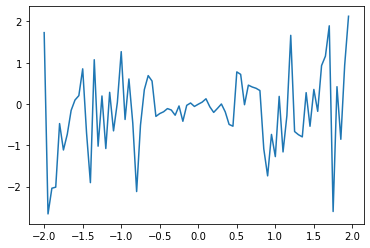

In [ ]:
plt.plot(X,y)

tensor([ 6.6820e-03, -8.6800e-01, -1.6063e-01,  2.3810e-01, -4.7320e+00,
        -7.9283e+00, -1.6819e-01,  3.7944e+00, -5.9401e+00,  5.0544e+00])